## Google Colab PRO (little flex 🤓 )

In [1]:
# GPU Test if 'Not connected to a GPU' go Runtime > Change runtime type > GPU > GPU Premium
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
# High-RAM Test if 'Not using a high-RAM runtime' go Runtime > Change runtime type > RAM > High-RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# load libraries
import pandas as pd
import os
import numpy as np
import datetime
# from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torch import save

In [ ]:
# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change me, have to point to the Meteotrentino drive folder
wk =  "/content/drive/My Drive/10. Meteotrentino/"

# folder for the csv
subfolder = "CSVs/"

# select the filename, make me dynamic
selected_dataset = "temperature.csv"

In [ ]:
# data_path = wk+subfolder+selected_dataset
data_path = "../../../vel_vento_A.csv"

In [ ]:
df_row_data = pd.read_csv(
  data_path,
  sep = ";", # not a CSV, separator is ';'
  header = None, # no header
  dtype = {'0' : str, '1': str, '2': str, '3' : np.float64, '4':int} # Daniele: added the validation code so we can train on validated data (no need of classes, just distinguish between good and bad data)
  ) 



In [ ]:
# define a header 
df_row_data = df_row_data.set_axis(
    ['label', 'date', 'time', 'value','validation_code'],
    axis = 1,
    inplace = False

)

In [ ]:
df_row_data['datetime'] = pd.to_datetime(df_row_data['date']+" "+df_row_data['time'], format = '%d/%m/%Y %H:%M')


In [ ]:
# econde the date as integer
df_row_data['datetime_enconded'] = np.int64(df_row_data['datetime'].astype(int)/10**9)
df_row_data

,label,date,time,value,validation_code,datetime,datetime_enconded
0,T0010,01/01/2014,00:00,0.2,1,2014-01-01 00:00:00,1388534400
1,T0010,01/01/2014,00:10,0.5,1,2014-01-01 00:10:00,1388535000
2,T0010,01/01/2014,00:20,0.2,1,2014-01-01 00:20:00,1388535600
3,T0010,01/01/2014,00:30,0.2,1,2014-01-01 00:30:00,1388536200
4,T0010,01/01/2014,00:40,0.1,1,2014-01-01 00:40:00,1388536800
...,...,...,...,...,...,...,...
12995756,T0469,31/12/2021,23:10,0.9,145,2021-12-31 23:10:00,1640992200
12995757,T0469,31/12/2021,23:20,0.6,145,2021-12-31 23:20:00,1640992800
12995758,T0469,31/12/2021,23:30,0.5,145,2021-12-31 23:30:00,1640993400
12995759,T0469,31/12/2021,23:40,0.7,145,2021-12-31 23:40:00,1640994000


In [ ]:
# split the dataframe by date

date_start = df_row_data['datetime'].min()

date_end = df_row_data['datetime'].max()


# period
period_split = 24 #hours

current_data = date_start

df_row_data['period_index'] = [-1]*len(df_row_data['datetime'])

i = 0
while current_data < date_end:

  offset_data = current_data+ pd.offsets.Hour(period_split)
  
  df_row_data['period_index'][(df_row_data['datetime'] < offset_data) & (df_row_data['datetime'] >= current_data)] = i

  current_data = offset_data
  i = i+1


/tmp/ipykernel_4620/3647555548.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_row_data['period_index'][(df_row_data['datetime'] < offset_data) & (df_row_data['datetime'] >= current_data)] = i


In [ ]:
# df_row_data.loc[df_row_data['label']=='T0429']
print( np.unique(df_row_data['label'],return_counts=True))

(array(['T0010', 'T0065', 'T0071', 'T0074', 'T0103', 'T0104', 'T0118',
       'T0129', 'T0135', 'T0146', 'T0147', 'T0153', 'T0193', 'T0354',
       'T0355', 'T0360', 'T0366', 'T0367', 'T0368', 'T0369', 'T0374',
       'T0379', 'T0384', 'T0414', 'T0417', 'T0420', 'T0421', 'T0423',
       'T0437', 'T0450', 'T0469'], dtype=object), array([420559, 420093, 420383, 419964, 420570, 417733, 420557, 420503,
       420481, 420509, 420526, 420096, 419721, 420230, 417889, 420123,
       420310, 418525, 419557, 417720, 417208, 419649, 403864, 420407,
       420324, 417778, 419167, 420444, 420491, 420280, 420100]))
(array([  1, 140, 145, 255]), array([112133,   1869, 306556,      1]))


In [ ]:
print( np.unique(df_row_data.loc[df_row_data['label']=='T0071']['validation_code'],return_counts=True))

(array([  1, 140, 145, 255]), array([195188,   8288, 216906,      1]))


In [ ]:
data_arr = []

for station in ['T0010','T0071']:
  df_station = df_row_data.loc[df_row_data['label']==station]
  for pk in np.unique(df_station['period_index']):
    df_subset = df_station.loc[(df_row_data['period_index'] == pk)]
    
    if df_subset.empty:
      continue

    if((df_subset['validation_code'].values != 1).any()):
      val_label = 1
    else:
      val_label = 0

    header={
      'label':df_subset['label'].values[0],
      'in_datetime':df_subset['datetime'].values[0],
      'in_datetime_int':df_subset['datetime_enconded'].values[0],
      'val_label':val_label
    }

    features = df_subset['value'].reset_index(drop=True).to_dict()
    data_arr.append({**header,**features})
df_row_data_converted = pd.DataFrame(data_arr)

In [ ]:
df_row_data_converted.loc[df_row_data_converted['val_label']==0]

,label,in_datetime,in_datetime_int,val_label,0,1,2,3,4,5,...,135,136,137,138,139,140,141,142,143,144
0,T0010,2014-01-01,1388534400,0,0.2,0.5,0.2,0.2,0.1,0.0,...,0.2,0.3,0.1,0.3,0.4,0.3,0.1,0.4,0.3,NaN
1,T0010,2014-01-02,1388620800,0,0.4,0.5,0.4,0.5,0.4,0.4,...,0.2,0.2,0.2,0.1,0.2,0.0,0.0,0.2,0.4,NaN
2,T0010,2014-01-03,1388707200,0,0.2,0.1,0.1,0.0,0.0,0.2,...,0.1,0.4,0.4,0.5,0.3,0.3,0.3,0.3,0.4,NaN
3,T0010,2014-01-04,1388793600,0,0.2,0.2,0.3,0.4,0.1,0.0,...,0.7,0.8,0.6,0.8,0.9,0.4,0.6,0.4,0.7,NaN
4,T0010,2014-01-05,1388880000,0,0.6,0.6,0.8,0.8,0.3,0.3,...,0.5,0.7,0.5,0.3,0.2,0.2,0.2,0.1,0.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4276,T0071,2017-09-16,1505520000,0,0.8,0.1,0.2,0.3,0.3,0.5,...,0.3,0.7,0.8,0.6,0.2,0.7,0.2,0.0,0.0,NaN
4277,T0071,2017-09-17,1505606400,0,0.8,0.4,0.3,0.5,1.0,0.4,...,1.0,0.7,0.8,1.2,0.9,0.8,0.6,0.2,0.0,NaN
4278,T0071,2017-09-18,1505692800,0,0.4,0.5,0.7,0.6,0.3,0.3,...,0.5,0.8,0.6,0.6,0.7,0.6,0.2,0.6,NaN,NaN
4279,T0071,2017-09-19,1505779200,0,0.4,0.7,0.4,0.8,0.7,0.8,...,0.5,0.9,0.8,1.3,1.4,0.2,0.8,1.2,0.6,NaN


In [ ]:
import torch
# create pythorc class for the data

class CustomDataset(Dataset):
  def __init__(self, df, transform = None, target_transform = None):
    self.features = torch.FloatTensor(df.drop(['label','in_datetime','in_datetime_int','val_label'],axis=1).values)
    ### standardize the data
    mean, std= torch.mean(self.features,0), torch.std(self.features,0)
    self.features = (self.features-mean)/std

    self.label = df['label'].values
    self.in_datetime = df['in_datetime'].values
    self.in_datetime_int = df['in_datetime_int'].values
    self.val_label = df['val_label'].values
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    features = self.features[idx]
    label = self.label[idx]
    date = self.in_datetime[idx]
    val_label = self.val_label[idx]
    return {"label": label, "features": features, "val_label":val_label, "date":date}


In [ ]:
# define the dataset and split in train and test
splits = ['train','test']
shuffle = {'train':True,'test':False}
dataset = {}

df_row_data_converted = df_row_data_converted.drop([144],axis=1)
df_row_data_converted = df_row_data_converted.dropna().reset_index(drop=True)

good_samples = df_row_data_converted.loc[df_row_data_converted['val_label']==0]
bad_samples = df_row_data_converted.loc[df_row_data_converted['val_label']==1]
# Test dataframe is made of all bad samples plus an equal number of good ones
# test_part_good = good_samples.sample(n = len(bad_samples))
# test = pd.concat([test_part_good, bad_samples], axis = 0)
test = bad_samples

# Train dataframe is made of all good samples 
# train = good_samples.drop(test_part_good.index)
train = good_samples

dataset['train'] = CustomDataset(train)
dataset['test'] = CustomDataset( test )
b_size = {'train':12,'test':len(dataset['test'])}

dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x)
                                            #num_workers=int(opt.workers),
                                            #drop_last=drop_last_batch[x],
                                            #worker_init_fn=(None if opt.manualseed == -1
                                            #else lambda x: np.random.seed(opt.manualseed)))
            for x in splits}




>> Training model AE_1D.


100%|██████████| 163/163 [00:00<00:00, 405.69it/s]


>> Training model AE_1D. Epoch 1/100
>> Training loss: 1.7982332706451416
>> Validation loss: 1.093491554260254


100%|██████████| 163/163 [00:00<00:00, 416.30it/s]


>> Training model AE_1D. Epoch 2/100
>> Training loss: 0.8503598570823669
>> Validation loss: 1.0162975788116455


100%|██████████| 163/163 [00:00<00:00, 432.68it/s]


>> Training model AE_1D. Epoch 3/100
>> Training loss: 1.2220864295959473
>> Validation loss: 0.9257073998451233


100%|██████████| 163/163 [00:00<00:00, 428.10it/s]


>> Training model AE_1D. Epoch 4/100
>> Training loss: 0.9171295166015625
>> Validation loss: 0.811332106590271


100%|██████████| 163/163 [00:00<00:00, 436.11it/s]


>> Training model AE_1D. Epoch 5/100
>> Training loss: 0.42146649956703186
>> Validation loss: 0.671506404876709


100%|██████████| 163/163 [00:00<00:00, 422.68it/s]


>> Training model AE_1D. Epoch 6/100
>> Training loss: 0.6691257953643799
>> Validation loss: 0.5318013429641724


100%|██████████| 163/163 [00:00<00:00, 417.09it/s]


>> Training model AE_1D. Epoch 7/100
>> Training loss: 0.7862608432769775
>> Validation loss: 0.43347010016441345


100%|██████████| 163/163 [00:00<00:00, 446.76it/s]


>> Training model AE_1D. Epoch 8/100
>> Training loss: 0.4099947214126587
>> Validation loss: 0.3809879720211029


100%|██████████| 163/163 [00:00<00:00, 437.62it/s]


>> Training model AE_1D. Epoch 9/100
>> Training loss: 0.45103660225868225
>> Validation loss: 0.35164743661880493


100%|██████████| 163/163 [00:00<00:00, 405.17it/s]


>> Training model AE_1D. Epoch 10/100
>> Training loss: 0.5653296709060669
>> Validation loss: 0.33239173889160156


100%|██████████| 163/163 [00:00<00:00, 433.01it/s]


>> Training model AE_1D. Epoch 11/100
>> Training loss: 0.2678948640823364
>> Validation loss: 0.3173338770866394


100%|██████████| 163/163 [00:00<00:00, 456.20it/s]


>> Training model AE_1D. Epoch 12/100
>> Training loss: 0.33407142758369446
>> Validation loss: 0.30338725447654724


100%|██████████| 163/163 [00:00<00:00, 428.09it/s]


>> Training model AE_1D. Epoch 13/100
>> Training loss: 0.5904824733734131
>> Validation loss: 0.28990912437438965


100%|██████████| 163/163 [00:00<00:00, 399.97it/s]


>> Training model AE_1D. Epoch 14/100
>> Training loss: 0.613396406173706
>> Validation loss: 0.27605295181274414


100%|██████████| 163/163 [00:00<00:00, 391.35it/s]


>> Training model AE_1D. Epoch 15/100
>> Training loss: 0.28461799025535583
>> Validation loss: 0.2617616355419159


100%|██████████| 163/163 [00:00<00:00, 384.69it/s]


>> Training model AE_1D. Epoch 16/100
>> Training loss: 0.3556612730026245
>> Validation loss: 0.24704551696777344


100%|██████████| 163/163 [00:00<00:00, 334.59it/s]


>> Training model AE_1D. Epoch 17/100
>> Training loss: 0.22527077794075012
>> Validation loss: 0.23244886100292206


100%|██████████| 163/163 [00:00<00:00, 309.74it/s]


>> Training model AE_1D. Epoch 18/100
>> Training loss: 0.4413720369338989
>> Validation loss: 0.21730922162532806


100%|██████████| 163/163 [00:00<00:00, 400.19it/s]


>> Training model AE_1D. Epoch 19/100
>> Training loss: 0.24315465986728668
>> Validation loss: 0.20281431078910828


100%|██████████| 163/163 [00:00<00:00, 387.61it/s]


>> Training model AE_1D. Epoch 20/100
>> Training loss: 0.5162479877471924
>> Validation loss: 0.18890027701854706


100%|██████████| 163/163 [00:00<00:00, 376.08it/s]


>> Training model AE_1D. Epoch 21/100
>> Training loss: 0.1557718962430954
>> Validation loss: 0.17608974874019623


100%|██████████| 163/163 [00:00<00:00, 372.82it/s]


>> Training model AE_1D. Epoch 22/100
>> Training loss: 0.27854469418525696
>> Validation loss: 0.16455508768558502


100%|██████████| 163/163 [00:00<00:00, 397.36it/s]


>> Training model AE_1D. Epoch 23/100
>> Training loss: 0.23846660554409027
>> Validation loss: 0.15448696911334991


100%|██████████| 163/163 [00:00<00:00, 423.83it/s]


>> Training model AE_1D. Epoch 24/100
>> Training loss: 0.13399916887283325
>> Validation loss: 0.14602819085121155


100%|██████████| 163/163 [00:00<00:00, 401.88it/s]


>> Training model AE_1D. Epoch 25/100
>> Training loss: 0.14148542284965515
>> Validation loss: 0.138818621635437


100%|██████████| 163/163 [00:00<00:00, 420.48it/s]


>> Training model AE_1D. Epoch 26/100
>> Training loss: 0.1588069051504135
>> Validation loss: 0.1329067498445511


100%|██████████| 163/163 [00:00<00:00, 440.14it/s]


>> Training model AE_1D. Epoch 27/100
>> Training loss: 0.2839958965778351
>> Validation loss: 0.12773370742797852


100%|██████████| 163/163 [00:00<00:00, 392.65it/s]


>> Training model AE_1D. Epoch 28/100
>> Training loss: 0.12034617364406586
>> Validation loss: 0.1235557273030281


100%|██████████| 163/163 [00:00<00:00, 389.53it/s]


>> Training model AE_1D. Epoch 29/100
>> Training loss: 0.2081461101770401
>> Validation loss: 0.11949293315410614


100%|██████████| 163/163 [00:00<00:00, 408.59it/s]


>> Training model AE_1D. Epoch 30/100
>> Training loss: 0.20270875096321106
>> Validation loss: 0.11605771631002426


100%|██████████| 163/163 [00:00<00:00, 363.63it/s]


>> Training model AE_1D. Epoch 31/100
>> Training loss: 0.08604387193918228
>> Validation loss: 0.11305491626262665


100%|██████████| 163/163 [00:00<00:00, 420.57it/s]


>> Training model AE_1D. Epoch 32/100
>> Training loss: 0.10571328550577164
>> Validation loss: 0.11001093685626984


100%|██████████| 163/163 [00:00<00:00, 403.97it/s]


>> Training model AE_1D. Epoch 33/100
>> Training loss: 0.37809550762176514
>> Validation loss: 0.10750972479581833


100%|██████████| 163/163 [00:00<00:00, 422.73it/s]


>> Training model AE_1D. Epoch 34/100
>> Training loss: 0.14251963794231415
>> Validation loss: 0.10488934069871902


100%|██████████| 163/163 [00:00<00:00, 424.57it/s]


>> Training model AE_1D. Epoch 35/100
>> Training loss: 0.2158907800912857
>> Validation loss: 0.10236114263534546


100%|██████████| 163/163 [00:00<00:00, 414.25it/s]


>> Training model AE_1D. Epoch 36/100
>> Training loss: 0.15976683795452118
>> Validation loss: 0.09972026944160461


100%|██████████| 163/163 [00:00<00:00, 434.58it/s]


>> Training model AE_1D. Epoch 37/100
>> Training loss: 0.13695794343948364
>> Validation loss: 0.09778935462236404


100%|██████████| 163/163 [00:00<00:00, 422.88it/s]


>> Training model AE_1D. Epoch 38/100
>> Training loss: 0.08328943699598312
>> Validation loss: 0.09575418382883072


100%|██████████| 163/163 [00:00<00:00, 446.71it/s]


>> Training model AE_1D. Epoch 39/100
>> Training loss: 0.22642938792705536
>> Validation loss: 0.09343728423118591


100%|██████████| 163/163 [00:00<00:00, 433.40it/s]


>> Training model AE_1D. Epoch 40/100
>> Training loss: 0.23737947642803192
>> Validation loss: 0.09155452251434326


100%|██████████| 163/163 [00:00<00:00, 349.73it/s]


>> Training model AE_1D. Epoch 41/100
>> Training loss: 0.12615063786506653
>> Validation loss: 0.08965565264225006


100%|██████████| 163/163 [00:00<00:00, 445.62it/s]


>> Training model AE_1D. Epoch 42/100
>> Training loss: 0.10920466482639313
>> Validation loss: 0.08727724105119705


100%|██████████| 163/163 [00:00<00:00, 433.76it/s]


>> Training model AE_1D. Epoch 43/100
>> Training loss: 0.2488766312599182
>> Validation loss: 0.08546753972768784


100%|██████████| 163/163 [00:00<00:00, 446.40it/s]


>> Training model AE_1D. Epoch 44/100
>> Training loss: 0.17616915702819824
>> Validation loss: 0.08381840586662292


100%|██████████| 163/163 [00:00<00:00, 411.67it/s]


>> Training model AE_1D. Epoch 45/100
>> Training loss: 0.04349435493350029
>> Validation loss: 0.08196205645799637


100%|██████████| 163/163 [00:00<00:00, 433.99it/s]


>> Training model AE_1D. Epoch 46/100
>> Training loss: 0.2234448790550232
>> Validation loss: 0.08006070554256439


100%|██████████| 163/163 [00:00<00:00, 395.00it/s]


>> Training model AE_1D. Epoch 47/100
>> Training loss: 0.1797812283039093
>> Validation loss: 0.07824360579252243


100%|██████████| 163/163 [00:00<00:00, 413.58it/s]


>> Training model AE_1D. Epoch 48/100
>> Training loss: 0.09102858603000641
>> Validation loss: 0.0765739157795906


100%|██████████| 163/163 [00:00<00:00, 436.71it/s]


>> Training model AE_1D. Epoch 49/100
>> Training loss: 0.12522463500499725
>> Validation loss: 0.07502913475036621


100%|██████████| 163/163 [00:00<00:00, 382.25it/s]


>> Training model AE_1D. Epoch 50/100
>> Training loss: 0.2504199743270874
>> Validation loss: 0.07338757812976837


100%|██████████| 163/163 [00:00<00:00, 356.34it/s]


>> Training model AE_1D. Epoch 51/100
>> Training loss: 0.6154983043670654
>> Validation loss: 0.07172505557537079


100%|██████████| 163/163 [00:00<00:00, 400.97it/s]


>> Training model AE_1D. Epoch 52/100
>> Training loss: 0.14040222764015198
>> Validation loss: 0.07010240107774734


100%|██████████| 163/163 [00:00<00:00, 416.07it/s]


>> Training model AE_1D. Epoch 53/100
>> Training loss: 0.0778990089893341
>> Validation loss: 0.068527951836586


100%|██████████| 163/163 [00:00<00:00, 408.89it/s]


>> Training model AE_1D. Epoch 54/100
>> Training loss: 0.0629950761795044
>> Validation loss: 0.06710836291313171


100%|██████████| 163/163 [00:00<00:00, 414.85it/s]


>> Training model AE_1D. Epoch 55/100
>> Training loss: 0.05103233829140663
>> Validation loss: 0.06546180695295334


100%|██████████| 163/163 [00:00<00:00, 421.27it/s]


>> Training model AE_1D. Epoch 56/100
>> Training loss: 0.06626072525978088
>> Validation loss: 0.06394219398498535


100%|██████████| 163/163 [00:00<00:00, 424.17it/s]


>> Training model AE_1D. Epoch 57/100
>> Training loss: 0.037870850414037704
>> Validation loss: 0.062472909688949585


100%|██████████| 163/163 [00:00<00:00, 429.48it/s]


>> Training model AE_1D. Epoch 58/100
>> Training loss: 0.08104467391967773
>> Validation loss: 0.06087397411465645


100%|██████████| 163/163 [00:00<00:00, 343.54it/s]


>> Training model AE_1D. Epoch 59/100
>> Training loss: 0.08583319187164307
>> Validation loss: 0.059367433190345764


100%|██████████| 163/163 [00:00<00:00, 401.64it/s]


>> Training model AE_1D. Epoch 60/100
>> Training loss: 0.049094147980213165
>> Validation loss: 0.05802203714847565


100%|██████████| 163/163 [00:00<00:00, 431.63it/s]


>> Training model AE_1D. Epoch 61/100
>> Training loss: 0.038643889129161835
>> Validation loss: 0.05652175471186638


100%|██████████| 163/163 [00:00<00:00, 412.59it/s]


>> Training model AE_1D. Epoch 62/100
>> Training loss: 0.0658038854598999
>> Validation loss: 0.05509372055530548


100%|██████████| 163/163 [00:00<00:00, 410.44it/s]


>> Training model AE_1D. Epoch 63/100
>> Training loss: 0.14825129508972168
>> Validation loss: 0.05365236848592758


100%|██████████| 163/163 [00:00<00:00, 377.32it/s]


>> Training model AE_1D. Epoch 64/100
>> Training loss: 0.05078859627246857
>> Validation loss: 0.05212145298719406


100%|██████████| 163/163 [00:00<00:00, 435.93it/s]


>> Training model AE_1D. Epoch 65/100
>> Training loss: 0.037062231451272964
>> Validation loss: 0.05078062787652016


100%|██████████| 163/163 [00:00<00:00, 424.12it/s]


>> Training model AE_1D. Epoch 66/100
>> Training loss: 0.05818643048405647
>> Validation loss: 0.04947744309902191


100%|██████████| 163/163 [00:00<00:00, 410.48it/s]


>> Training model AE_1D. Epoch 67/100
>> Training loss: 0.12382965534925461
>> Validation loss: 0.04818093776702881


100%|██████████| 163/163 [00:00<00:00, 402.98it/s]


>> Training model AE_1D. Epoch 68/100
>> Training loss: 0.05687713623046875
>> Validation loss: 0.046888191252946854


100%|██████████| 163/163 [00:00<00:00, 377.36it/s]


>> Training model AE_1D. Epoch 69/100
>> Training loss: 0.04585238918662071
>> Validation loss: 0.045688431710004807


100%|██████████| 163/163 [00:00<00:00, 449.25it/s]


>> Training model AE_1D. Epoch 70/100
>> Training loss: 0.08362916111946106
>> Validation loss: 0.044425610452890396


100%|██████████| 163/163 [00:00<00:00, 402.27it/s]


>> Training model AE_1D. Epoch 71/100
>> Training loss: 0.10780788958072662
>> Validation loss: 0.043406981974840164


100%|██████████| 163/163 [00:00<00:00, 400.97it/s]


>> Training model AE_1D. Epoch 72/100
>> Training loss: 0.04466770589351654
>> Validation loss: 0.042512744665145874


100%|██████████| 163/163 [00:00<00:00, 418.09it/s]


>> Training model AE_1D. Epoch 73/100
>> Training loss: 0.05440656468272209
>> Validation loss: 0.04140152409672737


100%|██████████| 163/163 [00:00<00:00, 416.31it/s]


>> Training model AE_1D. Epoch 74/100
>> Training loss: 0.061081886291503906
>> Validation loss: 0.04049331694841385


100%|██████████| 163/163 [00:00<00:00, 433.61it/s]


>> Training model AE_1D. Epoch 75/100
>> Training loss: 0.15734203159809113
>> Validation loss: 0.03959084674715996


100%|██████████| 163/163 [00:00<00:00, 416.11it/s]


>> Training model AE_1D. Epoch 76/100
>> Training loss: 0.06639359891414642
>> Validation loss: 0.038831375539302826


100%|██████████| 163/163 [00:00<00:00, 395.29it/s]


>> Training model AE_1D. Epoch 77/100
>> Training loss: 0.05585281178355217
>> Validation loss: 0.038180332630872726


100%|██████████| 163/163 [00:00<00:00, 424.23it/s]


>> Training model AE_1D. Epoch 78/100
>> Training loss: 0.09944736212491989
>> Validation loss: 0.03739003837108612


100%|██████████| 163/163 [00:00<00:00, 399.74it/s]


>> Training model AE_1D. Epoch 79/100
>> Training loss: 0.06431373953819275
>> Validation loss: 0.03675178438425064


100%|██████████| 163/163 [00:00<00:00, 434.19it/s]


>> Training model AE_1D. Epoch 80/100
>> Training loss: 0.0816977322101593
>> Validation loss: 0.0360335037112236


100%|██████████| 163/163 [00:00<00:00, 417.75it/s]


>> Training model AE_1D. Epoch 81/100
>> Training loss: 0.05832598730921745
>> Validation loss: 0.0354643240571022


100%|██████████| 163/163 [00:00<00:00, 410.69it/s]


>> Training model AE_1D. Epoch 82/100
>> Training loss: 0.04613213241100311
>> Validation loss: 0.035048842430114746


100%|██████████| 163/163 [00:00<00:00, 447.37it/s]


>> Training model AE_1D. Epoch 83/100
>> Training loss: 0.06422434002161026
>> Validation loss: 0.034328047186136246


100%|██████████| 163/163 [00:00<00:00, 403.08it/s]


>> Training model AE_1D. Epoch 84/100
>> Training loss: 0.04888084530830383
>> Validation loss: 0.03407903388142586


100%|██████████| 163/163 [00:00<00:00, 428.62it/s]


>> Training model AE_1D. Epoch 85/100
>> Training loss: 0.04215138405561447
>> Validation loss: 0.03359348326921463


100%|██████████| 163/163 [00:00<00:00, 393.69it/s]


>> Training model AE_1D. Epoch 86/100
>> Training loss: 0.07266251742839813
>> Validation loss: 0.03326432406902313


100%|██████████| 163/163 [00:00<00:00, 362.06it/s]


>> Training model AE_1D. Epoch 87/100
>> Training loss: 0.09016944468021393
>> Validation loss: 0.032721176743507385


100%|██████████| 163/163 [00:00<00:00, 307.77it/s]


>> Training model AE_1D. Epoch 88/100
>> Training loss: 0.0923861712217331
>> Validation loss: 0.032324403524398804


100%|██████████| 163/163 [00:00<00:00, 431.27it/s]


>> Training model AE_1D. Epoch 89/100
>> Training loss: 0.031478267163038254
>> Validation loss: 0.03193281963467598


100%|██████████| 163/163 [00:00<00:00, 441.40it/s]


>> Training model AE_1D. Epoch 90/100
>> Training loss: 0.03128621727228165
>> Validation loss: 0.0315396673977375


100%|██████████| 163/163 [00:00<00:00, 414.70it/s]


>> Training model AE_1D. Epoch 91/100
>> Training loss: 0.09776166826486588
>> Validation loss: 0.03113379515707493


100%|██████████| 163/163 [00:00<00:00, 434.55it/s]


>> Training model AE_1D. Epoch 92/100
>> Training loss: 0.03294188529253006
>> Validation loss: 0.031006736680865288


100%|██████████| 163/163 [00:00<00:00, 425.24it/s]


>> Training model AE_1D. Epoch 93/100
>> Training loss: 0.06251686066389084
>> Validation loss: 0.030475540086627007


100%|██████████| 163/163 [00:00<00:00, 415.07it/s]


>> Training model AE_1D. Epoch 94/100
>> Training loss: 0.04462551325559616
>> Validation loss: 0.030207203701138496


100%|██████████| 163/163 [00:00<00:00, 421.15it/s]


>> Training model AE_1D. Epoch 95/100
>> Training loss: 0.15270526707172394
>> Validation loss: 0.029902758076786995


100%|██████████| 163/163 [00:00<00:00, 399.67it/s]


>> Training model AE_1D. Epoch 96/100
>> Training loss: 0.061960525810718536
>> Validation loss: 0.029740432277321815


100%|██████████| 163/163 [00:00<00:00, 409.93it/s]


>> Training model AE_1D. Epoch 97/100
>> Training loss: 0.08467259258031845
>> Validation loss: 0.029291780665516853


100%|██████████| 163/163 [00:00<00:00, 448.15it/s]


>> Training model AE_1D. Epoch 98/100
>> Training loss: 0.05333711951971054
>> Validation loss: 0.029092485085129738


100%|██████████| 163/163 [00:00<00:00, 415.67it/s]


>> Training model AE_1D. Epoch 99/100
>> Training loss: 0.027808478102087975
>> Validation loss: 0.02883869968354702


100%|██████████| 163/163 [00:00<00:00, 417.79it/s]


>> Training model AE_1D. Epoch 100/100
>> Training loss: 0.10652139782905579
>> Validation loss: 0.02864190936088562
>> Training model AE_1D.[Done]


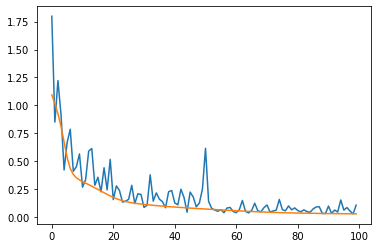

In [ ]:
from importlib import reload  # Python 3.4+
import model_simpleAE
model_simpleAE = reload(model_simpleAE)
from model_simpleAE import AE_1D
from options import Options

class configuration(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# LOAD MODEL
opt_dict = {
    'batchsize': 12, 
    'isize': 96, ## number of features
    'device': 'cpu',
    'name': 'try1', ## name of experiment
    'outf': './output', ## path to save the model
    'phase': 'train',
    'iter': 0, ## initial iteration step
    'niter': 100, ## number of steps
    'lr': 1e-5, ## learning rate
}

opt = configuration(opt_dict)
opt.isTrain = True

model = AE_1D(opt, dataloader)
##
# TRAIN MODEL
metrics = model.train()

metrics = pd.DataFrame(metrics)
import matplotlib.pyplot as plt
plt.plot(metrics['loss_tr'])
plt.plot(metrics['loss_val'])

In [ ]:
which = 132
sample = next(iter(dataloader['test']))
sample_tensor = torch.stack([v["features"] for v in sample])
# sample_validation = sample['val_label']
model.ae.eval()
with torch.no_grad():
    reconstructed = model.ae(sample_tensor)

mse = torch.nn.MSELoss(reduction='none')
def l2_loss_batch(x,x_hat):
    loss = mse(x,x_hat)
    loss = torch.sum(loss, dim=1) 
    # loss = torch.mean(loss)
    return loss
test_loss = l2_loss_batch(sample_tensor,reconstructed)
print(torch.argmax(test_loss))

# print(sample_validation)
# plt.plot(sample_tensor)
# plt.plot(reconstructed[0])
# plt.show()

tensor(2420)


In [ ]:
which = 2420
sample = next(iter(dataloader['test']))
sample_tensor = sample[which]['features']
sample_validation = sample[which]['val_label']
model.ae.eval()
with torch.no_grad():
    reconstructed = model.ae(torch.unsqueeze(sample_tensor,0))

print(sample_validation)
plt.plot(sample_tensor)
plt.plot(reconstructed[0])
plt.show()

In [ ]:
# save the classes in the typical pytorch class format

for i, class_d in enumerate(data_class_arr):
  
  save(class_d, wk + subfolder + "split_by_period/"+str(period_split)+"h/"+str(selected_dataset[:-4])+"/split_"+str(i)+".pt")
